In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
labels = ['malignant', 'benign']
img_size = 64

def get_training_data(data_dir):
    labels = ['benign', 'malignant']
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        if not os.path.exists(path):
            print(f"[!] Folder not found: {path}")
            continue

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img_array = cv2.imread(img_path)
                if img_array is None:
                    raise ValueError("Image could not be read (None)")
                resized_array = cv2.resize(img_array, (128, 128))
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"[X] Failed on {img_path}: {e}")

    return data


In [ ]:
train = get_training_data("/content/drive/MyDrive/train")
test = get_training_data("/content/drive/MyDrive/test")

Text(0.5, 1.0, 'malignant')

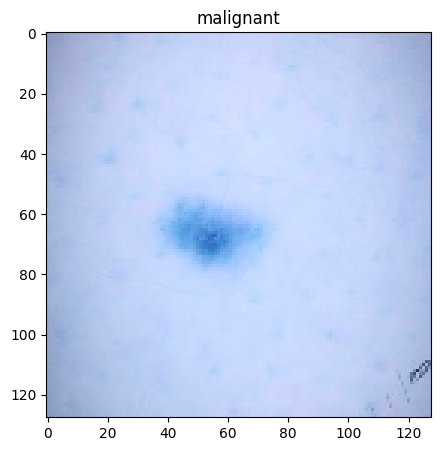

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0]/255)
plt.title(labels[train[0][1]])

In [ ]:
from sklearn.model_selection import train_test_split

X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)

img_size = 128
# resize data for deep learning
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Fit the data generator on training data
datagen.fit(X_train)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  accuracy_score, confusion_matrix
from keras import layers


# loading the model
pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(img_size,img_size , 3), pooling="max")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# make the model layers un trainable to use the saved weights

for i in pretrained_model.layers:
    i.trainable = False
# Fine-tune the ResNet50 model
# for layer in pretrained_model.layers[45:]:
#     layer.trainable = False
# for layer in pretrained_model.layers[:45]:
#     layer.trainable = True
# pretrained_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Set up ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# Build the model
model = Sequential()
model.add(pretrained_model)  # Add the pre-trained model
model.add(Dense(512, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(256, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(64, activation='relu'))  # Fully connected layer
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with both callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, lr_reduction],
                    epochs=40)
model.summary()
# Evaluate the model
best_model_scores = model.evaluate(X_test, y_test, verbose=0)
accuracy_resnet = best_model_scores[1] * 100
error_resnet =  1 - best_model_scores[1]

# Print the accuracy and error
print(f"Best Model Accuracy: {best_model_scores[1] * 100:.2f}% \nError: {(1 - best_model_scores[1]) * 100:.2f}%")

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6545 - loss: 1.2492
Epoch 1: val_loss improved from inf to 0.37625, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 224ms/step - accuracy: 0.6548 - loss: 1.2469 - val_accuracy: 0.8568 - val_loss: 0.3763 - learning_rate: 0.0010
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7986 - loss: 0.4623
Epoch 2: val_loss improved from 0.37625 to 0.34575, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.7987 - loss: 0.4622 - val_accuracy: 0.8766 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8305 - loss: 0.4038
Epoch 3: val_loss improved from 0.34575 to 0.29875, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.8305 - loss: 0.4037 - val_accuracy: 0.8808 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,155,589 (103.59 MB)

 Trainable params: 1,196,929 (4.57 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2,393,860 (9.13 MB)

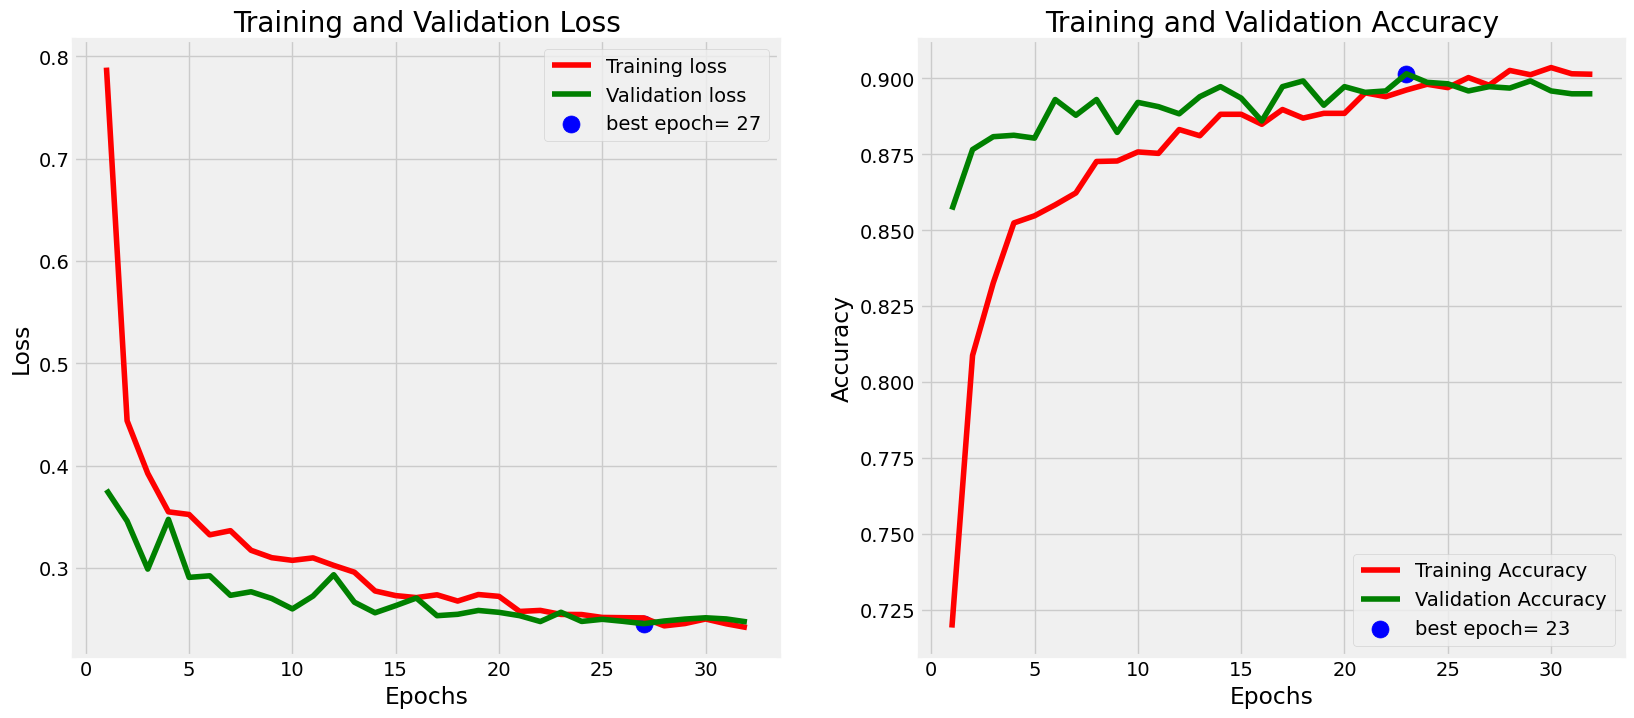

In [ ]:
# Define needed variables
hs = history.history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
              precision    recall  f1-score   support

   malignant       0.88      0.92      0.90      1084
      benign       0.91      0.87      0.89      1039

    accuracy                           0.89      2123
   macro avg       0.89      0.89      0.89      2123
weighted avg       0.89      0.89      0.89      2123



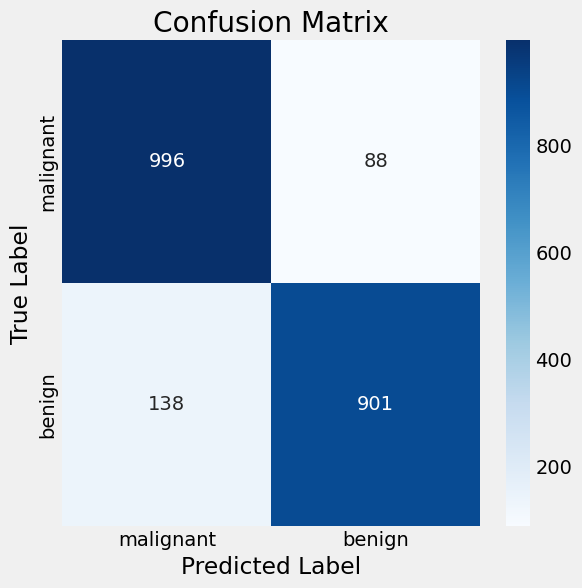

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
import seaborn as sns

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate Precision, Recall, F1-Score
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# loading the model
pretrained_model_vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_size,img_size , 3), pooling="max")
for i in pretrained_model_vgg.layers:
    i.trainable = False

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

lr_reduction_vgg = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# Build the model
model_vgg = Sequential()
model_vgg.add(pretrained_model_vgg)  # Add the pre-trained model
model_vgg.add(Dense(512, activation='relu'))  # Fully connected layer
model_vgg.add(Dropout(0.5))  # Dropout for regularization
model_vgg.add(Dense(256, activation='relu'))  # Fully connected layer
model_vgg.add(Dropout(0.5))  # Dropout for regularization
model_vgg.add(Dense(64, activation='relu'))  # Fully connected layer
model_vgg.add(Dropout(0.3))  # Dropout for regularization
model_vgg.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model_vgg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with both callbacks
history_vgg = model_vgg.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_vgg,lr_reduction_vgg],
                    epochs=40)
# Evaluate the model
best_model_scores_vgg = model_vgg.evaluate(X_test, y_test, verbose=0)
accuracy_vgg = best_model_scores_vgg[1] * 100
error_vgg = 1 - best_model_scores_vgg[1]

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 230ms/step - accuracy: 0.6730 - loss: 0.6093 - val_accuracy: 0.8512 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.8030 - loss: 0.4470 - val_accuracy: 0.8464 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 203ms/step - accuracy: 0.8287 - loss: 0.4069 - val_accuracy: 0.8672 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - accuracy: 0.8215 - loss: 0.4085 - val_accuracy: 0.8714 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.8267 - loss: 0.3929 - val_accuracy: 0.8742 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.8349 - loss: 0.3762 - val_accuracy: 0.8714 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 7/40
200/200 

In [ ]:
pretrained_model_dense = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=(img_size,img_size , 3), pooling="max")
for i in pretrained_model_dense.layers:
    i.trainable = False

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping_dense = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

lr_reduction_dense = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# Build the model
model_dense = Sequential()
model_dense.add(pretrained_model_dense)  # Add the pre-trained model
model_dense.add(Dense(512, activation='relu'))  # Fully connected layer
model_dense.add(Dropout(0.5))  # Dropout for regularization
model_dense.add(Dense(256, activation='relu'))  # Fully connected layer
model_dense.add(Dropout(0.5))  # Dropout for regularization
model_dense.add(Dense(64, activation='relu'))  # Fully connected layer
model_dense.add(Dropout(0.3))  # Dropout for regularization
model_dense.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with both callbacks
history_dense = model_dense.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_dense, lr_reduction_dense],
                    epochs=40)
# Evaluate the model
best_model_scores_dense = model_dense.evaluate(X_test, y_test, verbose=0)
accuracy_dense = best_model_scores_dense[1] * 100
error_dense = 1 - best_model_scores_dense[1]

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7299 - loss: 0.6391

In [ ]:
pretrained_model_eff = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_shape=(img_size,img_size , 3), pooling="max")
for i in pretrained_model_eff.layers:
    i.trainable = False

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping_eff = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

lr_reduction_eff = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# Build the model
model_eff = Sequential()
model_eff.add(pretrained_model_eff)  # Add the pre-trained model
# model_eff.add(Dense(512, activation='relu'))  # Fully connected layer
# model_eff.add(Dropout(0.5))  # Dropout for regularization
# model_eff.add(Dense(256, activation='relu'))  # Fully connected layer
# model_eff.add(Dropout(0.5))  # Dropout for regularization
# model_eff.add(Dense(64, activation='relu'))  # Fully connected layer
# model_eff.add(Dropout(0.3))  # Dropout for regularization
model_eff.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model_eff.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with both callbacks
history_eff = model_eff.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_eff, lr_reduction_eff],
                    epochs=40)
# Evaluate the model
best_model_scores_eff = model_eff.evaluate(X_test, y_test, verbose=0)
accuracy_eff = best_model_scores_eff[1] * 100
error_eff = 1 - best_model_scores_eff[1]
